In [1]:
from denovo_utils.parsers.converters import SpectralisParser, DenovoEngineConverter
import pandas as pd
import os

from matplotlib import pyplot as plt
import seaborn as sns

from psm_utils import PSM, PSMList
from tqdm import tqdm
tqdm.pandas()
from denovo_utils.analysis.mixture_models import filter_highest_cluster_psms

from denovo_utils.analysis.evaluation import get_precision_metrics

import warnings
warnings.filterwarnings("ignore")

# What are those non-matching identifications?

These analyses were performed from the perspective of using the de novo results as such. The results are filtered with the proposed approach and the high-scoring cluster is used as 'truth'.

Here, several metrics can be calculated:

### 1. Test the average accuracy of the selected set of identifications with GMM

There will be a large set of predictions of which the spectra were also assigned an identification with a database search engine. This, way, one can estimate the accuracy by only looking at the spectra which got assigned a significant target identifications at x% FDR. Ideally, the scores on these spectra are normally distributed across the set of predictions

The accuracy on this subset could be used as a lower-bound estimate of accuracy of the predictions at 1% FDR

As sanity check, the other subsets that correspond with decoy PSMs and rejected target PSMs should have very low accuracy metrics, ideally 1-accuracy_target_accepted

### 2. Check where the differences reside in the non-matching set

One can calculate several metrics on the identifications which are different.

- Levenschtein distance (normalized by peptide length)
- Difference in Hyperscore

After rescoring with a new percolator model using 4 scores: (spectralis-score), hyperscore, ms2pip_corr, rt_diff

- Difference in rescored percolator-score

-> Here, the best option can be choosen and the engine responsible for it is given a point.
At the end, based on all falsy hits, one can see which engine generally provides the best alternative. 


# 1. Test accuracy on ground-truth subsets of selected de novo predictions

In [2]:
df = pd.read_pickle("F06_merged.pkl")
df_db = df[df["source"]=="sage"]

engines = [
    "Casanovo4.2.0",
    "InstaNovo",
    "ContraNovo",
    "NovoB",
    "PepNet",
    "Novor",
    "PepNovo+"
]

In [4]:
spectra_target_accepted = df_db.loc[df_db["psm_type"]=="target_accepted", "spectrum_id"].tolist()
spectra_target_rejected = df_db.loc[df_db["psm_type"]=="target_rejected", "spectrum_id"].tolist()
spectra_decoy = df_db.loc[df_db["psm_type"]=="decoy", "spectrum_id"].tolist()

In [5]:

def evaluate_prediction(row, ground_truth):
    try:
        ground_truth_peptidoform = ground_truth[row["spectrum_id"]]["peptide"]
        return ground_truth_peptidoform == row["peptide"]

    except:
        return None

    
df["correct_prediction"] = df.apply(lambda x: evaluate_prediction(x, ground_truth), axis=1)

<Axes: xlabel='spectralis_score', ylabel='Density'>

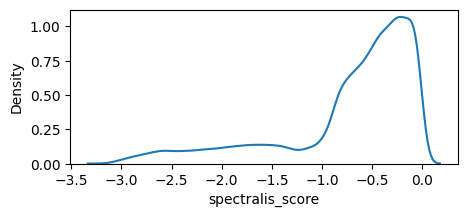

In [8]:
plt.figure(figsize=(5,2))
sns.kdeplot(df_filtered, x="spectralis_score")

In [9]:
print(len(df), len(df_filtered))

588585 230770


In [10]:
df_filtered = []

for engine in engines:
    subset = filter_highest_cluster_psms(
        df, source=engine, score_col="spectralis_score"
    )
    df_filtered.append(subset)

df_filtered = pd.concat(df_filtered+[df_db], ignore_index=True)

Mean: [-1.69476715 -0.44005902]
Covariance: [0.3005588  0.07899656]
Weights: [0.57127841 0.42872159]
Mean: [-0.46489664 -1.90170313]
Covariance: [0.09322216 0.30001458]
Weights: [0.43179384 0.56820616]
Mean: [-1.71837851 -0.41420985]
Covariance: [0.29423516 0.07196041]
Weights: [0.61176925 0.38823075]
Mean: [-1.87071152 -0.3837062 ]
Covariance: [0.29374453 0.06615471]
Weights: [0.6700148 0.3299852]
Mean: [-2.07621228 -0.36915542]
Covariance: [0.33558789 0.06352089]
Weights: [0.710585 0.289415]
Mean: [-0.32333867 -1.95957662]
Covariance: [0.05659333 0.25331423]
Weights: [0.16520316 0.83479684]
Mean: [-1.17055826 -1.86154601]
Covariance: [0.43800264 0.08737488]
Weights: [0.11925074 0.88074926]


In [11]:
def calculate_accuracy(df, source, subset_spectra):
    df_subset = df[
        (df["source"]==source) &
        (df["spectrum_id"].isin(subset_spectra))
    ]
    if len(df_subset)==0:
        return None, 0
    precision = df_subset["correct_prediction"].sum() / len(df_subset)

    coverage = len(df_subset)/len(subset_spectra)

    return precision, coverage

In [12]:
def calculate_all_accuracy_metrics(df):
    metrics_accuracy = {}
    metrics_coverage = {}
    extra_predictions = {}


    for engine in engines:
        accuracy_accepted, coverage_accepted = calculate_accuracy(
            df=df,
            source=engine,
            subset_spectra=spectra_target_accepted
        )
        accuracy_rejected, coverage_rejected = calculate_accuracy(
            df=df,
            source=engine,
            subset_spectra=spectra_target_rejected
        )
        accuracy_decoy, coverage_decoy = calculate_accuracy(
            df=df,
            source=engine,
            subset_spectra=spectra_decoy
        )
        metrics_accuracy[engine] = {
            "target_accepted": accuracy_accepted,
            "target_rejected": accuracy_rejected,
            "decoy": accuracy_decoy
        }
        metrics_coverage[engine] = {
            "target_accepted": coverage_accepted,
            "target_rejected": coverage_rejected,
            "decoy": coverage_decoy
        }

        subset = df[df.source==engine]
        extra_predictions_abs = subset["correct_prediction"].isna().sum() 
        extra_predictions_pct = extra_predictions_abs / len(subset)
        extra_predictions[engine] = {
            "pct": extra_predictions_pct,
            "absolute": extra_predictions_abs
        }
    return metrics_accuracy, metrics_coverage, extra_predictions

In [13]:
metrics_accuracy, metrics_coverage, extra_predictions = calculate_all_accuracy_metrics(
    df=df
)

metrics_accuracy_filtered, metrics_coverage_filtered, extra_predictions_filtered = calculate_all_accuracy_metrics(
    df=df_filtered
)

Text(0.5, 1.0, 'Accuracy of selected set of de novo predictions (FILTERED)')

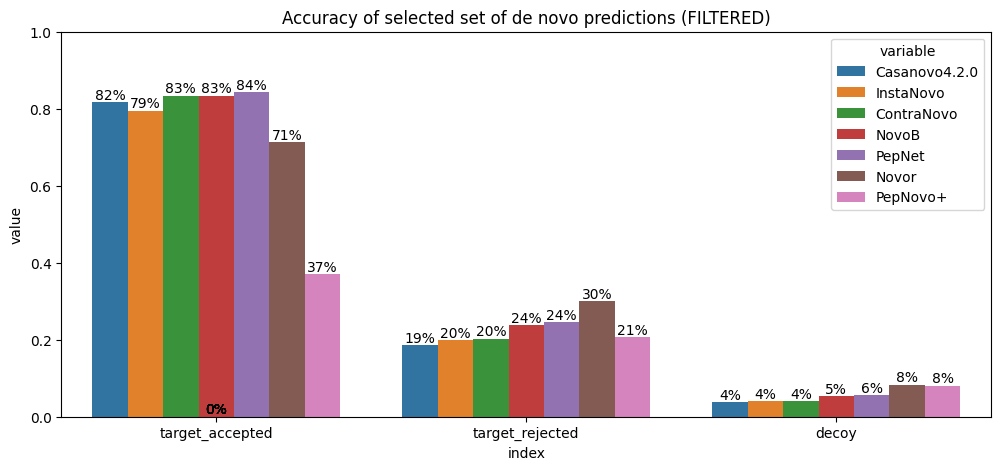

In [14]:
plt.figure(figsize=(12,5))
barplot=sns.barplot(
    pd.DataFrame(metrics_accuracy_filtered).reset_index().melt(id_vars="index"),
    x="index",
    y="value",
    hue="variable"
)
plt.ylim((0,1))

for p in barplot.patches:
    height = p.get_height()
    barplot.text(
        p.get_x() + p.get_width() / 2.0,  # X-coordinate: center of the bar
        height,  # Y-coordinate: height of the bar
        f'{height*100:.0f}%',  # Text to be displayed
        ha='center',  # Horizontal alignment
        va='bottom'   # Vertical alignment
    )
plt.title("Accuracy of selected set of de novo predictions (FILTERED)")

Text(0.5, 1.0, 'Accuracy of selected set of de novo predictions (UNFILTERED)')

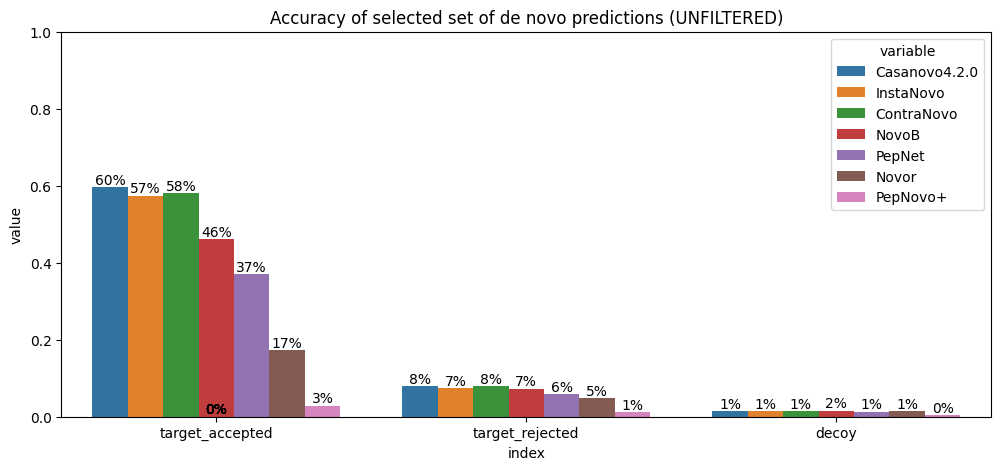

In [15]:
plt.figure(figsize=(12,5))
barplot=sns.barplot(
    pd.DataFrame(metrics_accuracy).reset_index().melt(id_vars="index"),
    x="index",
    y="value",
    hue="variable"
)
plt.ylim((0,1))

for p in barplot.patches:
    height = p.get_height()
    barplot.text(
        p.get_x() + p.get_width() / 2.0,  # X-coordinate: center of the bar
        height,  # Y-coordinate: height of the bar
        f'{height*100:.0f}%',  # Text to be displayed
        ha='center',  # Horizontal alignment
        va='bottom'   # Vertical alignment
    )
plt.title("Accuracy of selected set of de novo predictions (UNFILTERED)")

Text(0.5, 1.0, 'Coverage of selected set of de novo predictions (FILTERED)')

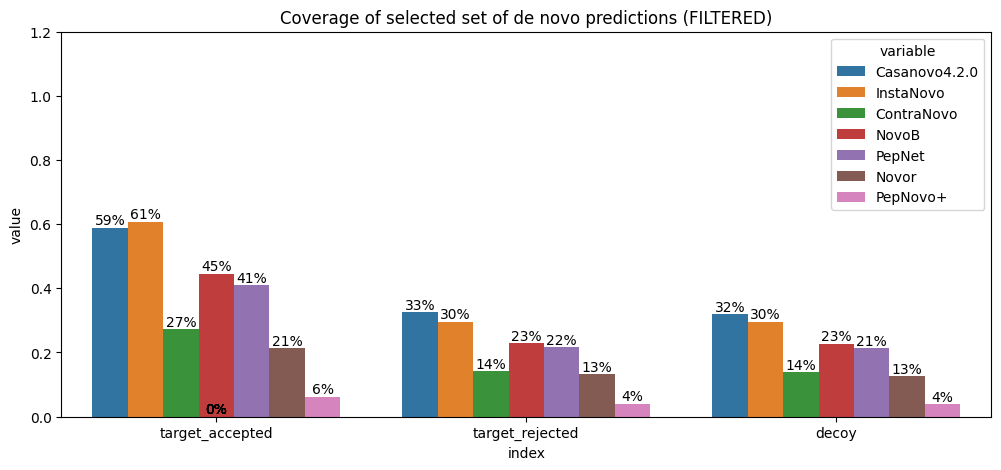

In [16]:
plt.figure(figsize=(12,5))
barplot=sns.barplot(
    pd.DataFrame(metrics_coverage_filtered).reset_index().melt(id_vars="index"),
    x="index",
    y="value",
    hue="variable"
)
plt.ylim((0,1.2))

for p in barplot.patches:
    height = p.get_height()
    barplot.text(
        p.get_x() + p.get_width() / 2.0,  # X-coordinate: center of the bar
        height,  # Y-coordinate: height of the bar
        f'{height*100:.0f}%',  # Text to be displayed
        ha='center',  # Horizontal alignment
        va='bottom'   # Vertical alignment
    )
plt.title("Coverage of selected set of de novo predictions (FILTERED)")

Text(0.5, 1.0, 'Coverage of selected set of de novo predictions (UNFILTERED)')

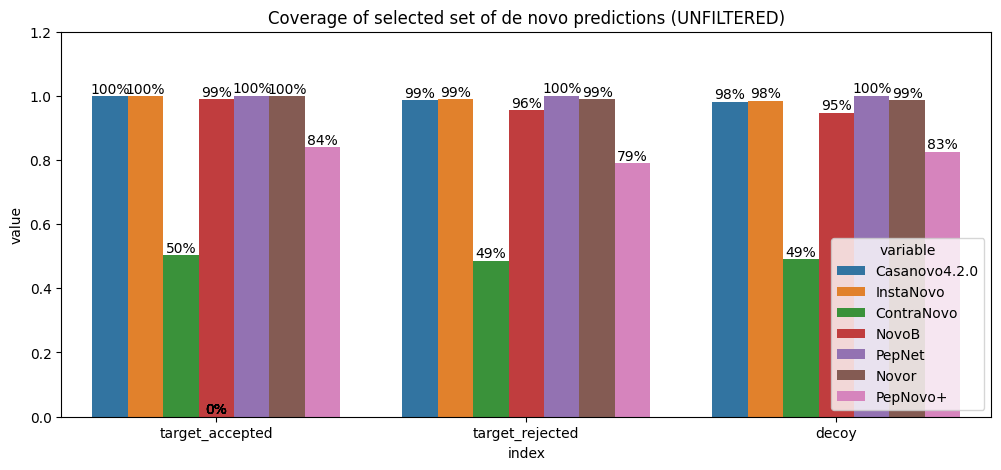

In [17]:
plt.figure(figsize=(12,5))
barplot=sns.barplot(
    pd.DataFrame(metrics_coverage).reset_index().melt(id_vars="index"),
    x="index",
    y="value",
    hue="variable"
)
plt.ylim((0,1.2))

for p in barplot.patches:
    height = p.get_height()
    barplot.text(
        p.get_x() + p.get_width() / 2.0,  # X-coordinate: center of the bar
        height,  # Y-coordinate: height of the bar
        f'{height*100:.0f}%',  # Text to be displayed
        ha='center',  # Horizontal alignment
        va='bottom'   # Vertical alignment
    )
plt.title("Coverage of selected set of de novo predictions (UNFILTERED)")

In [18]:
pd.DataFrame(extra_predictions).T

,pct,absolute
Casanovo4.2.0,0.065535,5298.0
InstaNovo,0.062730,5066.0
ContraNovo,0.066741,2706.0
NovoB,0.058985,4638.0
PepNet,0.084209,7005.0
Novor,0.064554,5226.0
PepNovo+,0.070117,4732.0


In [19]:
pd.DataFrame(extra_predictions_filtered).T

,pct,absolute
Casanovo4.2.0,0.003551,126.0
InstaNovo,0.002274,80.0
ContraNovo,0.002113,34.0
NovoB,0.002059,54.0
PepNet,0.002099,51.0
Novor,0.002322,31.0
PepNovo+,0.003027,12.0


Text(0.5, 1.0, '% spectra extra predicted by de novo tools above threshold (FILTERED)')

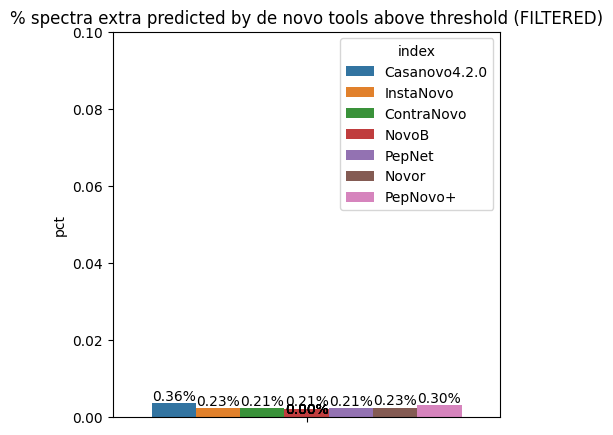

In [22]:
plt.figure(figsize=(5,5))
barplot=sns.barplot(
   pd.DataFrame(extra_predictions_filtered).T["pct"].reset_index(),
    y="pct",
    hue="index"
)
plt.ylim((0,.1))

for p in barplot.patches:
    height = p.get_height()
    barplot.text(
        p.get_x() + p.get_width() / 2.0,  # X-coordinate: center of the bar
        height,  # Y-coordinate: height of the bar
        f'{height*100:.2f}%',  # Text to be displayed
        ha='center',  # Horizontal alignment
        va='bottom'   # Vertical alignment
    )
plt.title("% spectra extra predicted by de novo tools above threshold (FILTERED)")

Text(0.5, 1.0, '% spectra extra predicted by de novo tools above threshold (UNFILTERED)')

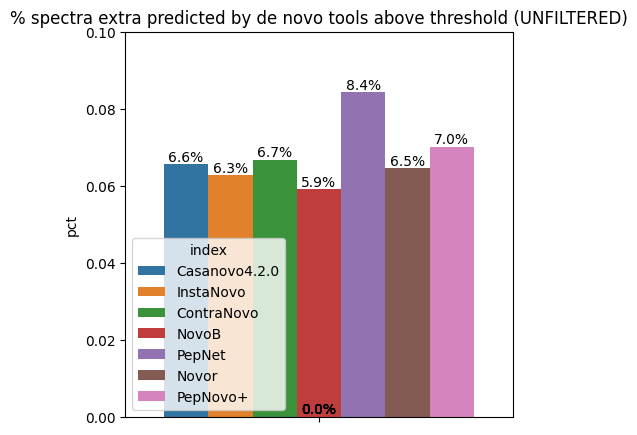

In [24]:
plt.figure(figsize=(5,5))
barplot=sns.barplot(
   pd.DataFrame(extra_predictions).T["pct"].reset_index(),
    y="pct",
    hue="index"
)
plt.ylim((0,.1))

for p in barplot.patches:
    height = p.get_height()
    barplot.text(
        p.get_x() + p.get_width() / 2.0,  # X-coordinate: center of the bar
        height,  # Y-coordinate: height of the bar
        f'{height*100:.1f}%',  # Text to be displayed
        ha='center',  # Horizontal alignment
        va='bottom'   # Vertical alignment
    )
plt.title("% spectra extra predicted by de novo tools above threshold (UNFILTERED)")

In [25]:
def annotate_spectra_psm_type(row, accepted, rejected, decoys):
    spectrum_id = row["spectrum_id"]
    if spectrum_id in accepted:
        return "target_accepted"
    elif spectrum_id in rejected:
        return "target_rejected"
    elif spectrum_id in decoys:
        return "decoy"
    else:
        return "unannotated"

100%|██████████| 3964/3964 [00:00<00:00, 5820.92it/s]


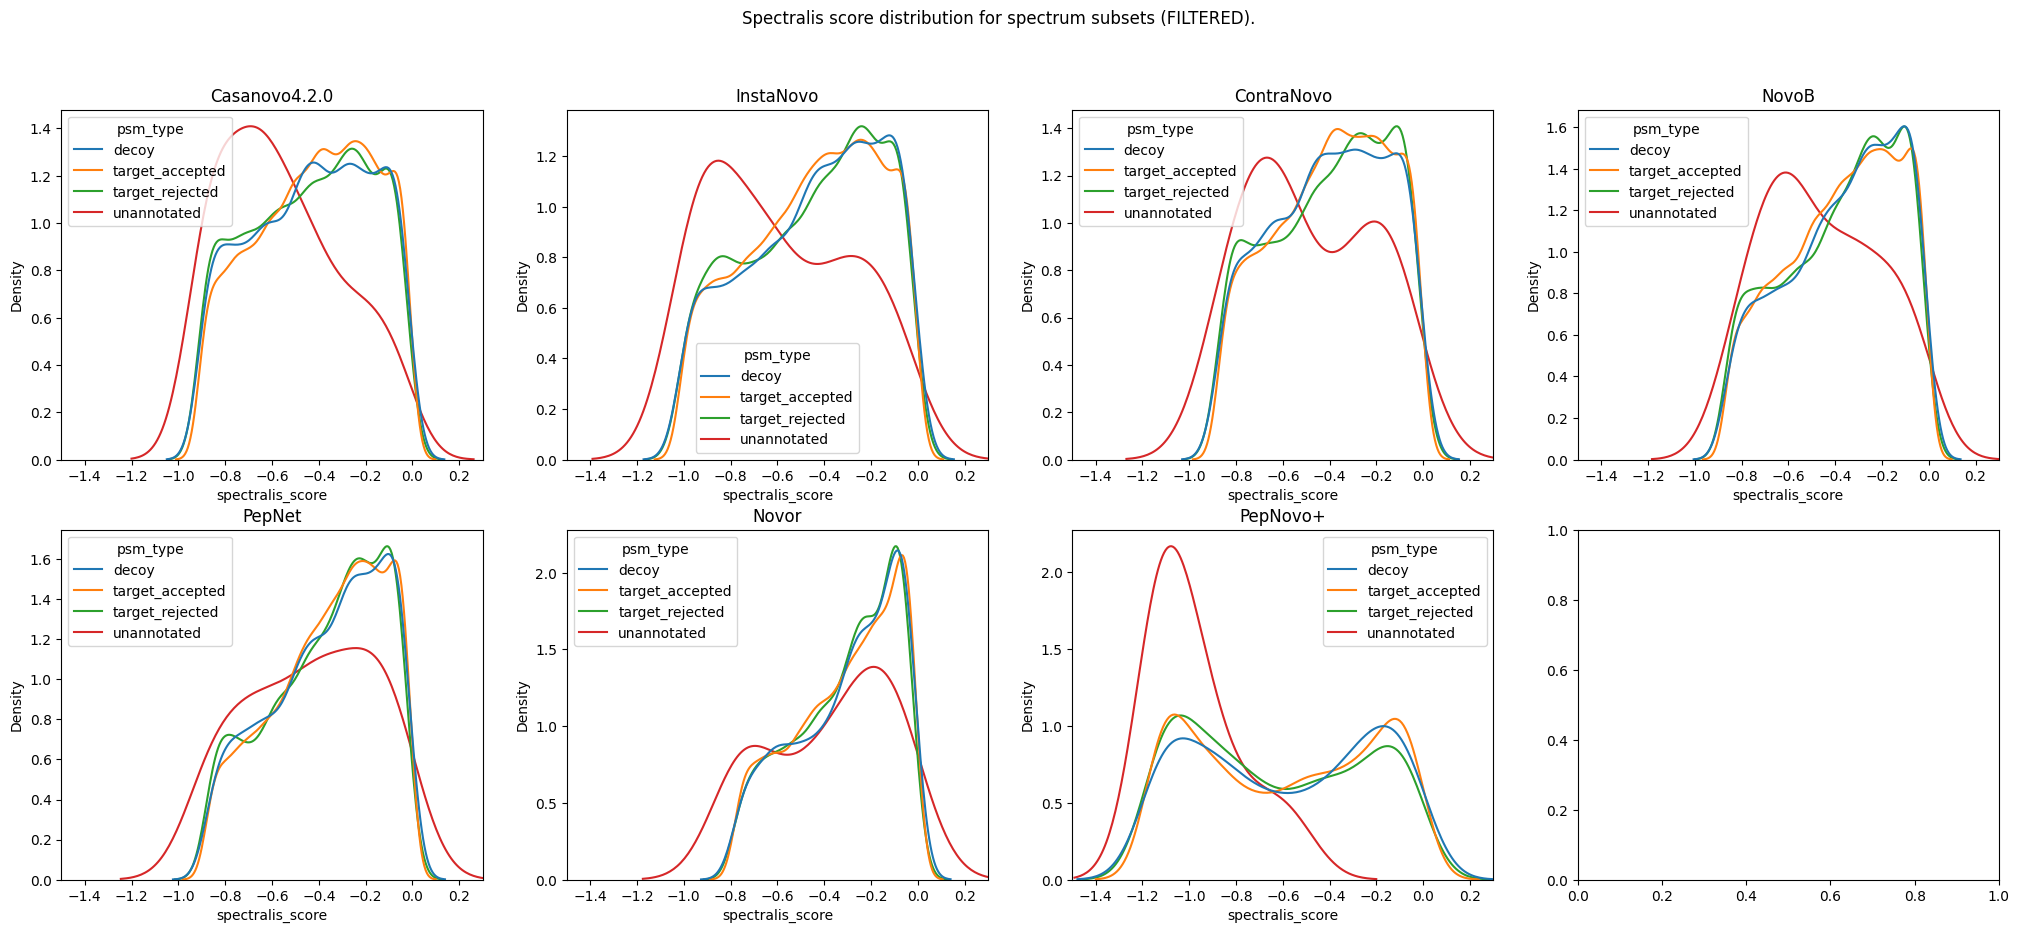

In [32]:
fig, ax = plt.subplots(2,4, figsize=(25,10))

x=0

fig.suptitle("Spectralis score distribution for spectrum subsets (FILTERED).")
for y, engine in enumerate(engines):
    if y >= 4:
        x=1
        y-=4
    selection = df_filtered[
        df_filtered.source==engine
    ].copy()
    selection["psm_type"] = selection.progress_apply(
        lambda x: annotate_spectra_psm_type(
            row=x,
            accepted=spectra_target_accepted,
            rejected=spectra_target_rejected,
            decoys=spectra_decoy
        ), 
        axis=1
    )

    sns.kdeplot(
        selection.sort_values("psm_type"),
        x="spectralis_score",
        hue="psm_type",
        ax=ax[x][y],
        common_norm=False
    )

    ax[x][y].set_xlim((-1.5, 0.3))
    ax[x][y].set_title("{}".format(engine))

100%|██████████| 67487/67487 [00:13<00:00, 4836.94it/s]


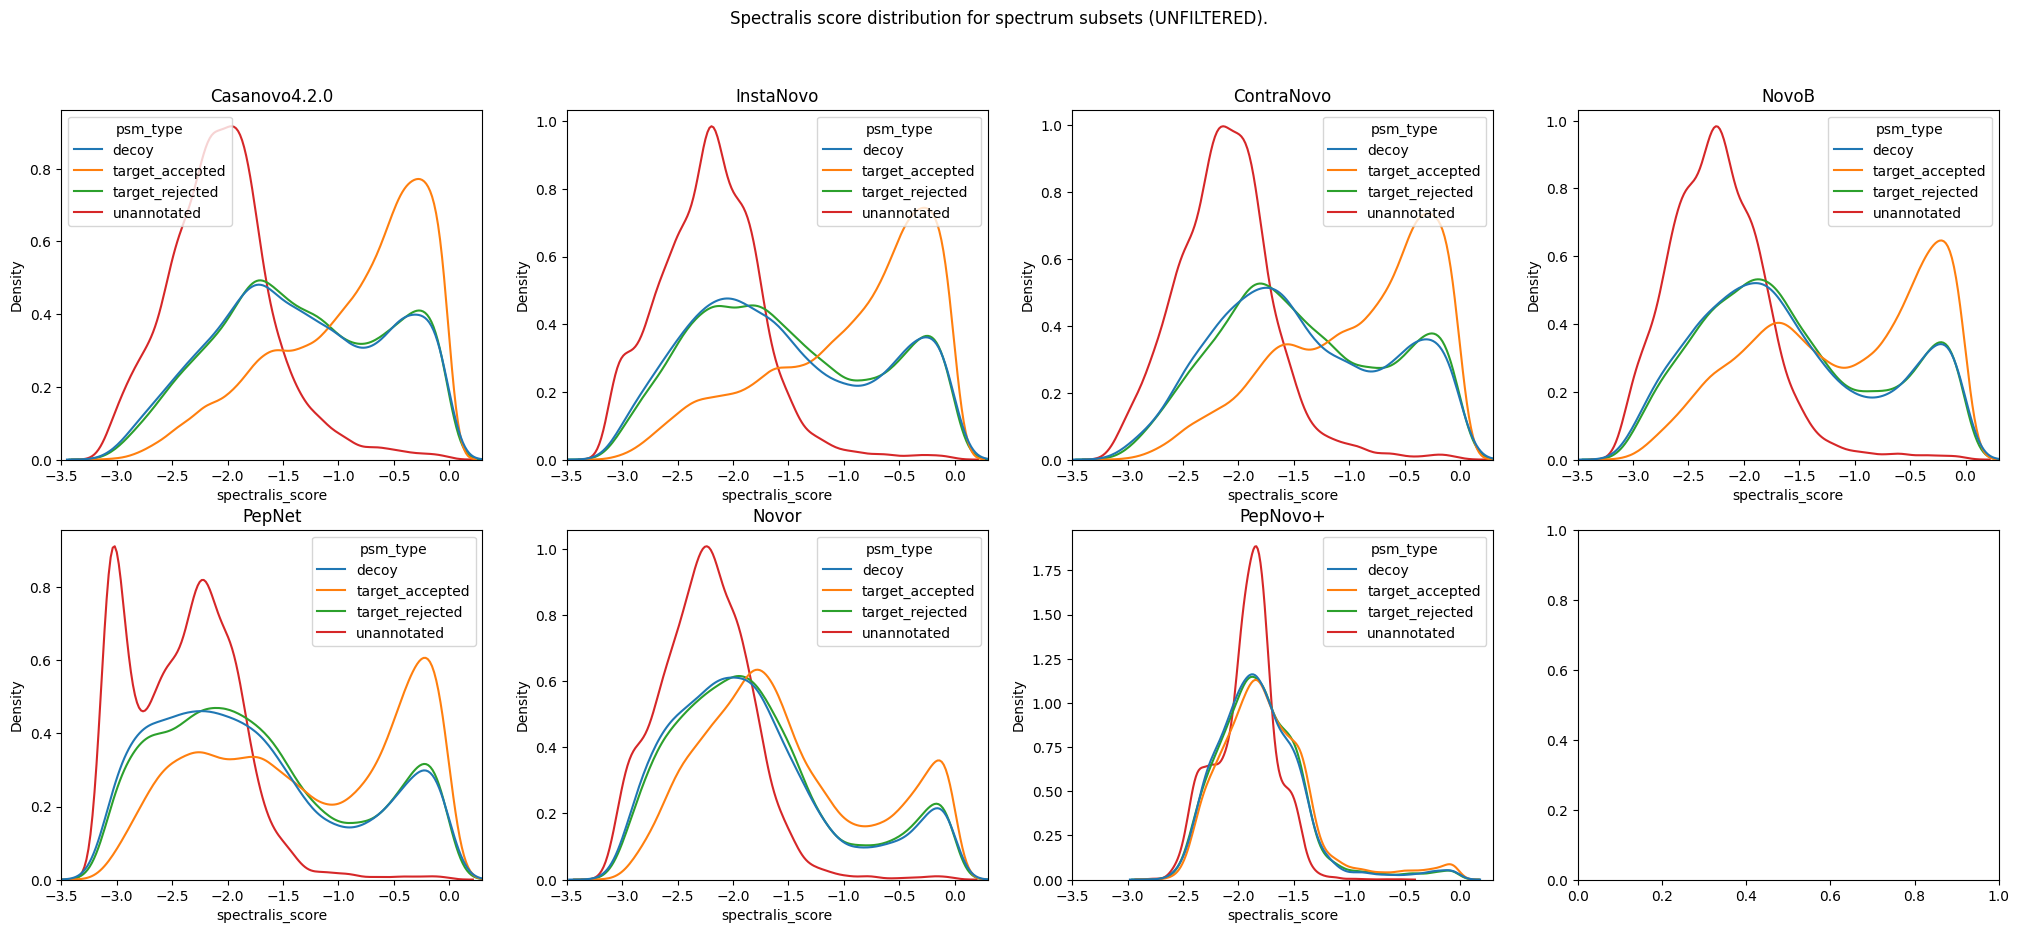

In [33]:
fig, ax = plt.subplots(2,4, figsize=(25,10))

x=0

fig.suptitle("Spectralis score distribution for spectrum subsets (UNFILTERED).")
for y, engine in enumerate(engines):
    if y >= 4:
        x=1
        y-=4
    selection = df[
        df.source==engine
    ].copy()
    selection["psm_type"] = selection.progress_apply(
        lambda x: annotate_spectra_psm_type(
            row=x,
            accepted=spectra_target_accepted,
            rejected=spectra_target_rejected,
            decoys=spectra_decoy
        ), 
        axis=1
    )

    sns.kdeplot(
        selection.sort_values("psm_type"),
        x="spectralis_score",
        hue="psm_type",
        ax=ax[x][y],
        common_norm=False
    )

    ax[x][y].set_xlim((-3.5, 0.3))
    ax[x][y].set_title("{}".format(engine))